In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
import random
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from pandas import DataFrame, Series
from patsy import dmatrices
from scipy import stats
from sklearn import metrics
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             confusion_matrix, ConfusionMatrixDisplay, 
                             average_precision_score, balanced_accuracy_score, 
                             matthews_corrcoef, roc_auc_score)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance



In [2]:
percentages_url = 'https://api.nhle.com/stats/rest/en/skater/percentages?limit=-1&cayenneExp=seasonId=20232024'
percentages_resp = requests.get(percentages_url)
percentages_json = percentages_resp.json()

In [3]:
df_percentages = DataFrame(percentages_json['data'])
df_percentages_filtered = df_percentages.loc[(df_percentages['positionCode'] != 'D') & (df_percentages['gamesPlayed'] >= 20)]
df_percentages_filtered = df_percentages_filtered.reset_index(drop=True)
df_percentages_filtered.drop(['skaterSavePct5v5', 'seasonId','shootingPct5v5', 'timeOnIcePerGame5v5', 'zoneStartPct5v5', 'satPercentage', 'satPercentageBehind', 'satPercentageAhead', 'satRelative', 'skaterShootingPlusSavePct5v5', 'usatPercentage', 'usatPercentageAhead', 'usatPercentageBehind', 'usatRelative'], axis=1, inplace=True)
df_percentages_filtered = df_percentages_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches','satPercentageClose',
 'satPercentageTied','usatPercentageTied', 'usatPrecentageClose']]

In [4]:
df_percentages_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,usatPrecentageClose
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,0.464,0.436,0.401,0.436
1,8475763,Kevin Hayes,Hayes,R,STL,79,L,0.450,0.443,0.430,0.436
2,8471698,T.J. Oshie,Oshie,R,WSH,56,R,0.433,0.416,0.411,0.431
3,8482259,Bobby McMann,McMann,C,TOR,56,L,0.523,0.518,0.509,0.530
4,8480748,Kiefer Sherwood,Sherwood,L,NSH,74,R,0.520,0.535,0.534,0.522
...,...,...,...,...,...,...,...,...,...,...,...
469,8478477,Mitchell Stephens,Stephens,C,MTL,23,R,0.412,0.444,0.493,0.444
470,8482157,Will Cuylle,Cuylle,L,NYR,97,L,0.485,0.493,0.516,0.501
471,8477952,Robby Fabbri,Fabbri,C,DET,68,L,0.418,0.417,0.418,0.422
472,8482652,Walker Duehr,Duehr,R,CGY,40,R,0.429,0.491,0.512,0.429


In [5]:
summary_url = 'https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId=20232024'
summary_resp = requests.get(summary_url)
summary_json = summary_resp.json()

In [6]:
df_summary = DataFrame(summary_json['data'])
df_summary_filtered = df_summary.loc[(df_summary['positionCode'] != 'D') & (df_summary['gamesPlayed'] >= 20)]
df_summary_filtered = df_summary_filtered.reset_index(drop=True)
df_summary_filtered.drop(['assists', 'evGoals', 'evPoints', 'faceoffWinPct', 'goals', 'penaltyMinutes', 'plusMinus', 'points', 'pointsPerGame', 'ppGoals', 'ppPoints', 'shPoints','shootingPct', 'shootsCatches', 'shots', 'timeOnIcePerGame', 'seasonId'], axis=1, inplace=True)
df_summary_filtered = df_summary_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'gameWinningGoals','otGoals', 'shGoals']]

In [7]:
df_summary_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,gameWinningGoals,otGoals,shGoals
0,8480039,Martin Necas,Necas,C,CAR,88,3,2,0
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,1,0,0
2,8481624,Ilya Mikheyev,Mikheyev,R,VAN,89,1,0,0
3,8477508,Curtis Lazar,Lazar,C,NJD,71,2,0,1
4,8482062,Cole Smith,Smith,L,NSH,85,4,0,1
...,...,...,...,...,...,...,...,...,...
469,8480068,Ryan Poehling,Poehling,C,PHI,77,1,0,3
470,8478477,Mitchell Stephens,Stephens,C,MTL,23,0,0,0
471,8480830,Andrei Svechnikov,Svechnikov,R,CAR,70,8,0,0
472,8473453,Trevor Lewis,Lewis,C,LAK,87,2,0,1


In [8]:
df_players_merged = pd.merge(df_percentages_filtered, df_summary_filtered, on = 'playerId')
df_players_merged.drop(['skaterFullName_y', 'lastName_y', 'positionCode_y', 'teamAbbrevs_y', 'gamesPlayed_y'], axis=1, inplace=True)
df_players_merged.columns = ['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']
df_players_merged = df_players_merged[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']]

In [9]:
percentages  = ['satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose']

for stat in percentages:
    df_players_merged[stat] *= 100

df_players_merged['teamAbbrevs'] = df_players_merged['teamAbbrevs'].apply(lambda x: x.split(',')[0].strip() if ',' in x else x)

In [10]:
def headshot(row):
    headshot_link = 'https://assets.nhle.com/mugs/nhl/20232024/' + str(row['teamAbbrevs']) + '/' + str(row['playerId']) + '.png'
    return headshot_link

df_players_merged['headshot'] = df_players_merged.apply(headshot, axis=1)

In [11]:
def logo(row):
    logo_link = 'https://assets.nhle.com/logos/nhl/svg/' + str(row['teamAbbrevs']) + '_dark.svg'
    return logo_link

df_players_merged['logo'] = df_players_merged.apply(logo, axis=1)

In [12]:
columns = ['satPercentageClose', 'satPercentageTied', 'usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals']

def percentile(row, column):
    percentile_score = stats.percentileofscore(df_players_merged[column], row[column])
    return percentile_score

for column in columns:
    df_players_merged[column + 'Percentile'] = df_players_merged.apply(lambda row: percentile(row, column), axis = 1)
    df_players_merged[column + 'Percentile'] = df_players_merged[column + 'Percentile'].round(2)

df_players_merged['tiedPercentile'] =  ((df_players_merged['satPercentageTiedPercentile'] + df_players_merged['usatPercentageTiedPercentile']) / 2).round(2)
df_players_merged['closePercentile'] = ((df_players_merged['usatPercentageClosePercentile'] + df_players_merged['satPercentageClosePercentile']) / 2).round(2)
df_players_merged['final'] = (0.3 * df_players_merged['tiedPercentile'] + 0.3 * df_players_merged['closePercentile'] + 0.4 * df_players_merged['gameWinningGoalsPercentile']).round(2)
df_players_merged['finalRank'] = df_players_merged['final'].rank(ascending=False)

In [13]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,...,logo,satPercentageClosePercentile,satPercentageTiedPercentile,usatPercentageTiedPercentile,usatPercentageClosePercentile,gameWinningGoalsPercentile,tiedPercentile,closePercentile,final,finalRank
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,46.4,43.6,40.1,...,https://assets.nhle.com/logos/nhl/svg/COL_dark...,27.94,15.13,3.99,13.76,36.97,9.56,20.85,23.91,399.0
1,8475763,Kevin Hayes,Hayes,R,STL,79,L,45.0,44.3,43.0,...,https://assets.nhle.com/logos/nhl/svg/STL_dark...,20.48,18.28,13.76,13.76,55.67,16.02,17.12,32.21,355.0
2,8471698,T.J. Oshie,Oshie,R,WSH,56,R,43.3,41.6,41.1,...,https://assets.nhle.com/logos/nhl/svg/WSH_dark...,12.82,8.61,7.25,11.55,80.78,7.93,12.18,38.35,320.0
3,8482259,Bobby McMann,McMann,C,TOR,56,L,52.3,51.8,50.9,...,https://assets.nhle.com/logos/nhl/svg/TOR_dark...,72.90,67.65,59.56,78.36,13.34,63.60,75.63,47.10,267.0
4,8480748,Kiefer Sherwood,Sherwood,L,NSH,74,R,52.0,53.5,53.4,...,https://assets.nhle.com/logos/nhl/svg/NSH_dark...,70.38,78.26,76.16,70.80,55.67,77.21,70.59,66.61,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8478477,Mitchell Stephens,Stephens,C,MTL,23,R,41.2,44.4,49.3,...,https://assets.nhle.com/logos/nhl/svg/MTL_dark...,5.15,18.59,47.58,17.12,13.34,33.08,11.14,18.60,418.0
472,8482157,Will Cuylle,Cuylle,L,NYR,97,L,48.5,49.3,51.6,...,https://assets.nhle.com/logos/nhl/svg/NYR_dark...,42.23,46.95,64.39,54.41,55.67,55.67,48.32,53.46,223.0
473,8477952,Robby Fabbri,Fabbri,C,DET,68,L,41.8,41.7,41.8,...,https://assets.nhle.com/logos/nhl/svg/DET_dark...,6.72,8.93,9.03,8.40,70.17,8.98,7.56,33.03,351.0
474,8482652,Walker Duehr,Duehr,R,CGY,40,R,42.9,49.1,51.2,...,https://assets.nhle.com/logos/nhl/svg/CGY_dark...,11.03,45.69,61.13,10.19,13.34,53.41,10.61,24.54,392.0


In [14]:
df_players_merged[['satPercentageClose', 'satPercentageTied', 'usatPercentageTied', 'usatPercentageClose']].describe(percentiles=[0.75, 0.8, 0.9])

,satPercentageClose,satPercentageTied,usatPercentageTied,usatPercentageClose
count,476.000000,476.000000,476.000000,476.000000
mean,49.243277,49.294328,49.371849,49.277731
std,4.980063,5.367198,5.360664,4.852625
min,33.100000,34.000000,34.700000,34.400000
50%,49.550000,49.650000,49.600000,49.600000
75%,52.600000,53.025000,53.200000,52.600000
80%,53.100000,53.900000,54.100000,53.100000
90%,54.850000,55.900000,56.000000,54.850000
max,62.700000,62.700000,63.900000,61.500000


In [15]:
df_players_merged[['gameWinningGoals', 'otGoals', 'shGoals']].describe(percentiles=[0.75, 0.8, 0.9])

,gameWinningGoals,otGoals,shGoals
count,476.000000,476.000000,476.000000
mean,2.302521,0.334034,0.462185
std,2.442793,0.704704,0.873371
min,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,3.000000,0.000000,1.000000
80%,4.000000,1.000000,1.000000
90%,5.000000,1.000000,2.000000
max,13.000000,4.000000,6.000000


In [16]:
gameWinningGoalsQuantile = df_players_merged['gameWinningGoals'].quantile(0.8)

def binary_clutchness(row):
    clutchness = (row['satPercentageClose'] >= 55) or (row['satPercentageTied'] >= 55) or (row['usatPercentageClose'] >= 55) or (row['usatPercentageTied'] >= 55) and (row['gameWinningGoals'] >= gameWinningGoalsQuantile)
    if clutchness:
        return 1
    else:
        return 0
        
df_players_merged['clutch_performance'] = df_players_merged.apply(binary_clutchness, axis=1)

In [17]:
df_players_merged['clutch_performance'].value_counts()

clutch_performance
0    394
1     82
Name: count, dtype: int64

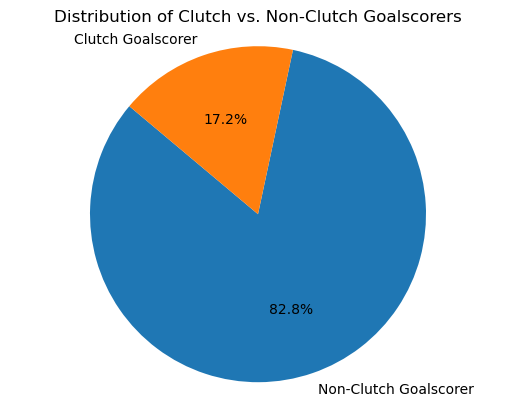

In [18]:
key = ['Non-Clutch Goalscorer', 'Clutch Goalscorer',]

plt.pie(df_players_merged['clutch_performance'].value_counts(), labels=key, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Clutch vs. Non-Clutch Goalscorers')
plt.axis('equal') 
plt.show()

In [19]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = ['clutch_performance']
train, test = train_test_split(df_players_merged, test_size = 0.3)

xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='mlogloss')
xgb_model.fit(train[x_var], train[y_var])

test['xgb_clutch_type'] = xgb_model.predict(test[x_var])
test['xgb_correct'] = (test['xgb_clutch_type'] == test['clutch_performance'])
xgb_accuracy = test['xgb_correct'].mean()
xgb_accuracy

0.972027972027972

In [20]:
'''import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import friedmanchisquare

x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

x = df_players_merged[x_var]
y = df_players_merged[y_var]

models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
}

metrics = {name: {'precision': [], 'recall': [], 'auc_pr': [], 'f1_score': []} for model_name in models}
def evaluate_model(model, x, y):
    precision_scores = []
    recall_scores = []
    auc_pr_scores = []
    f1_scores = []
    
    skf = StratifiedKFold(n_splits = 5)

    for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        model.fit(x_train_fold, y_train_fold)
        y_true = y_test_fold

        y_pred = model.predict(x_test_fold)
        y_pred_proba = model.predict_proba(x_test_fold)[:, 1]
            

        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
        auc_pr_scores.append(average_precision_score(y_true, y_pred_proba))
        f1_scores.append(f1_score(y_true, y_pred))

    return {
        'precision': precision_scores,
        'recall': recall_scores,
        'auc_pr': auc_pr_scores,
        'f1_score': f1_scores
    }


for model_name, model in models.items():
    results = evaluate_model(model, x, y)
    for metric in metrics[model_name]:
        metrics[model_name][metric] = results[metric]

data_for_tests = {
    'precision': [metrics[name]['precision'] for name in models],
    'recall': [metrics[name]['recall'] for name in models],
    'auc_pr': [metrics[name]['auc_pr'] for name in models],
    'f1_score': [metrics[name]['f1_score'] for name in models],
}

for metric, data in data_for_tests.items():
    stat, p = friedmanchisquare(*data)
    print(f'Friedman test for {metric.capitalize()}: statistic={stat}, p-value={p}')''

SyntaxError: incomplete input (1777348547.py, line 1)

In [ ]:
'''for model_name in metrics.keys():
    print(f"{model_name} recall: {metrics[model_name]['recall']}")'''
    

In [ ]:
'''import pandas as pd

# Extract precision scores
precision_data = []

for model_name, metrics_values in metrics.items():
    precision_scores = metrics_values['recall']
    
    for fold_index, score in enumerate(precision_scores):
        precision_data.append({
            'Model': model_name,
            'Fold': fold_index + 1,
            'Precision': score
        })

precision_df = pd.DataFrame(precision_data)

knn_precision = precision_df.loc[precision_df['Model'] == 'KNN', 'Precision'].values
random_forest_precision = precision_df.loc[precision_df['Model'] == 'Random Forest', 'Precision'].values
xgboost_forest_precision = precision_df.loc[precision_df['Model'] == 'XGBoost', 'Precision'].values

res = friedmanchisquare(knn_precision, random_forest_precision, xgboost_forest_precision)
print(res.statistic)
print(res.pvalue)

precision_df['Rank'] = precision_df.groupby('Fold')['Precision'].rank(ascending=False)

rank_sum = precision_df.groupby('Model')['Rank'].sum().reset_index()
rank_sum.columns = ['Model', 'Rank_Sum']
rank_sum['Sum Squared'] = rank_sum['Rank_Sum'] ** 2

chi_square = 12 / (10 * 3 * (3 + 1)) * rank_sum['Sum Squared'].sum() - 3 * 10 * (3 + 1)

print(chi_square)
'''

Friedman test for Precision: statistic=1.6000000000000227, p-value=0.44932896411721657
Friedman test for Recall: statistic=15.44000000000001, p-value=0.0004438606039028717

Metrics Summary for Recall (p < 0.05):
                    mean
KNN            0.813333
Random Forest  0.935556
XGBoost        0.922222
                    KNN  Random Forest   XGBoost
KNN            1.000000       0.061863  0.090850
Random Forest  0.061863       1.000000  0.732805
XGBoost        0.090850       0.732805  1.000000
Friedman test for Auc_pr: statistic=13.515151515151521, p-value=0.0011620428355683945

Metrics Summary for Auc_pr (p < 0.05):
                    mean
KNN            0.956947
Random Forest  0.996561
XGBoost        0.984524
                    KNN  Random Forest   XGBoost
KNN            1.000000       0.005416  0.083528
Random Forest  0.005416       1.000000  0.224776
XGBoost        0.083528       0.224776  1.000000
Friedman test for F1_score: statistic=15.235294117647046, p-value=0.00049169

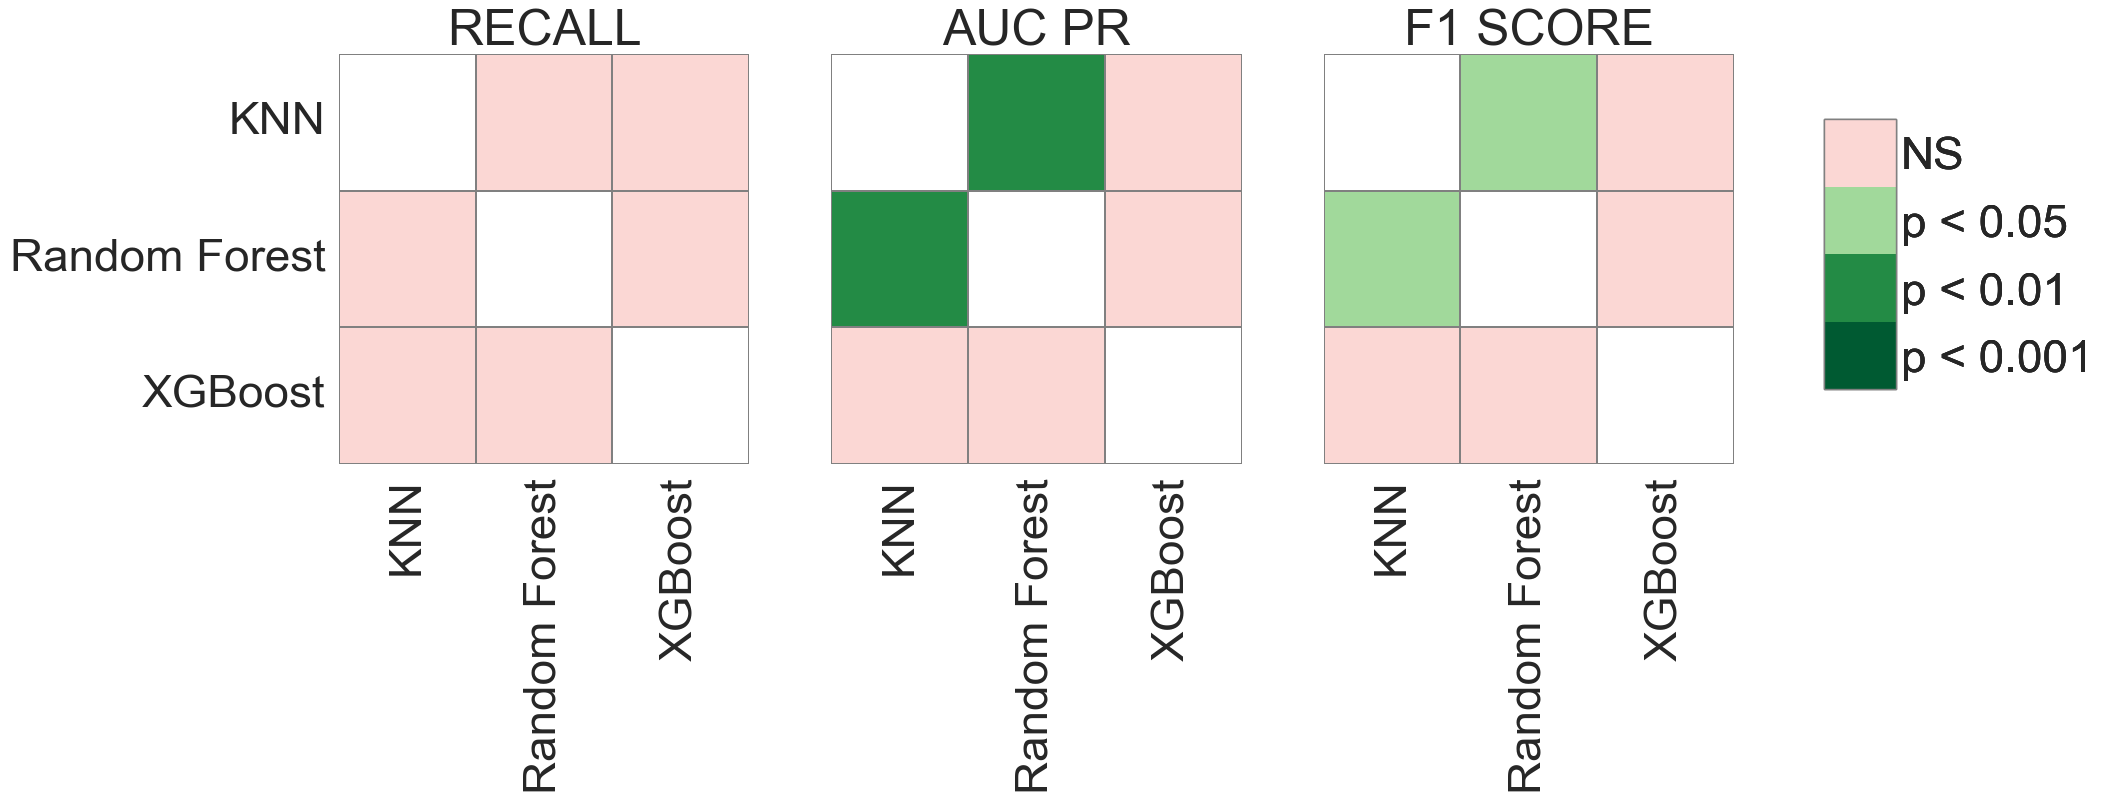

In [19]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp


x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

x = df_players_merged[x_var]
y = df_players_merged[y_var]

models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
    }

metrics_combined =  {'precision': [], 
     'recall': [], 
     'auc_pr': [], 
     'f1_score': []}

skf = StratifiedKFold(n_splits = 15)

def evaluate_model(model, x, y):
    precision_scores = []
    recall_scores = []
    auc_pr_scores = []
    f1_scores = []
    
    for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
        model.fit(x_train_fold, y_train_fold)
        y_true = y_test_fold
    
        y_pred = model.predict(x_test_fold)
        y_pred_proba = model.predict_proba(x_test_fold)[:, 1]
                
    
        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
        auc_pr_scores.append(average_precision_score(y_true, y_pred_proba))
        f1_scores.append(f1_score(y_true, y_pred))

    results = {
        'precision': precision_scores,
        'recall': recall_scores,
        'auc_pr': auc_pr_scores,
        'f1_score': f1_scores
    }
               
    return results
    
for model_name, model in models.items():
    scores = evaluate_model(model, x, y)
    for metric in scores:
        metrics_combined[metric].append(scores[metric])

sns.set(rc={'figure.figsize': (18, 9)}, font_scale = 3)
figure, axes = plt.subplots(1, 3, sharex = True, sharey= True)

i = 0

for name in metrics_combined:
    stat, p = friedmanchisquare(*metrics_combined[name])
    print(f'Friedman test for {name.capitalize()}: statistic={stat}, p-value={p}')
    
    if p < 0.05:
        df_scores = pd.DataFrame(metrics_combined[name]).T
        df_scores.columns = models.keys() 

        metrics_summary = df_scores.agg(['mean']).T
        print(f'\nMetrics Summary for {name.capitalize()} (p < 0.05):\n', metrics_summary)

        
        df_long = df_scores.melt(var_name='Model', value_name='Score')
        
        df = sp.posthoc_conover(df_long, group_col='Model', val_col='Score', p_adjust='holm')
        print(df)

        similarity_matrix = pd.DataFrame(df, index = models.keys())

        heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5',  'square': True}

        sub_ax, sub_c = sp.sign_plot(df, **heatmap_args, ax=axes[i])
        sub_ax.set_title(name.replace("_", " ").upper())
        i += 1
        if i >= 3:
            break

plt.show()


In [20]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

X = df_players_merged[x_var]
y = df_players_merged[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [21]:
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

scores = cross_validate(xgb_model, X, y, cv=5, scoring=scoring)

df = pd.DataFrame.from_dict(scores)

df.mean()

fit_time                  0.139572
score_time                0.020184
test_accuracy             0.983180
test_precision            0.951373
test_recall               0.952941
test_f1                   0.950758
test_average_precision    0.986245
dtype: float64

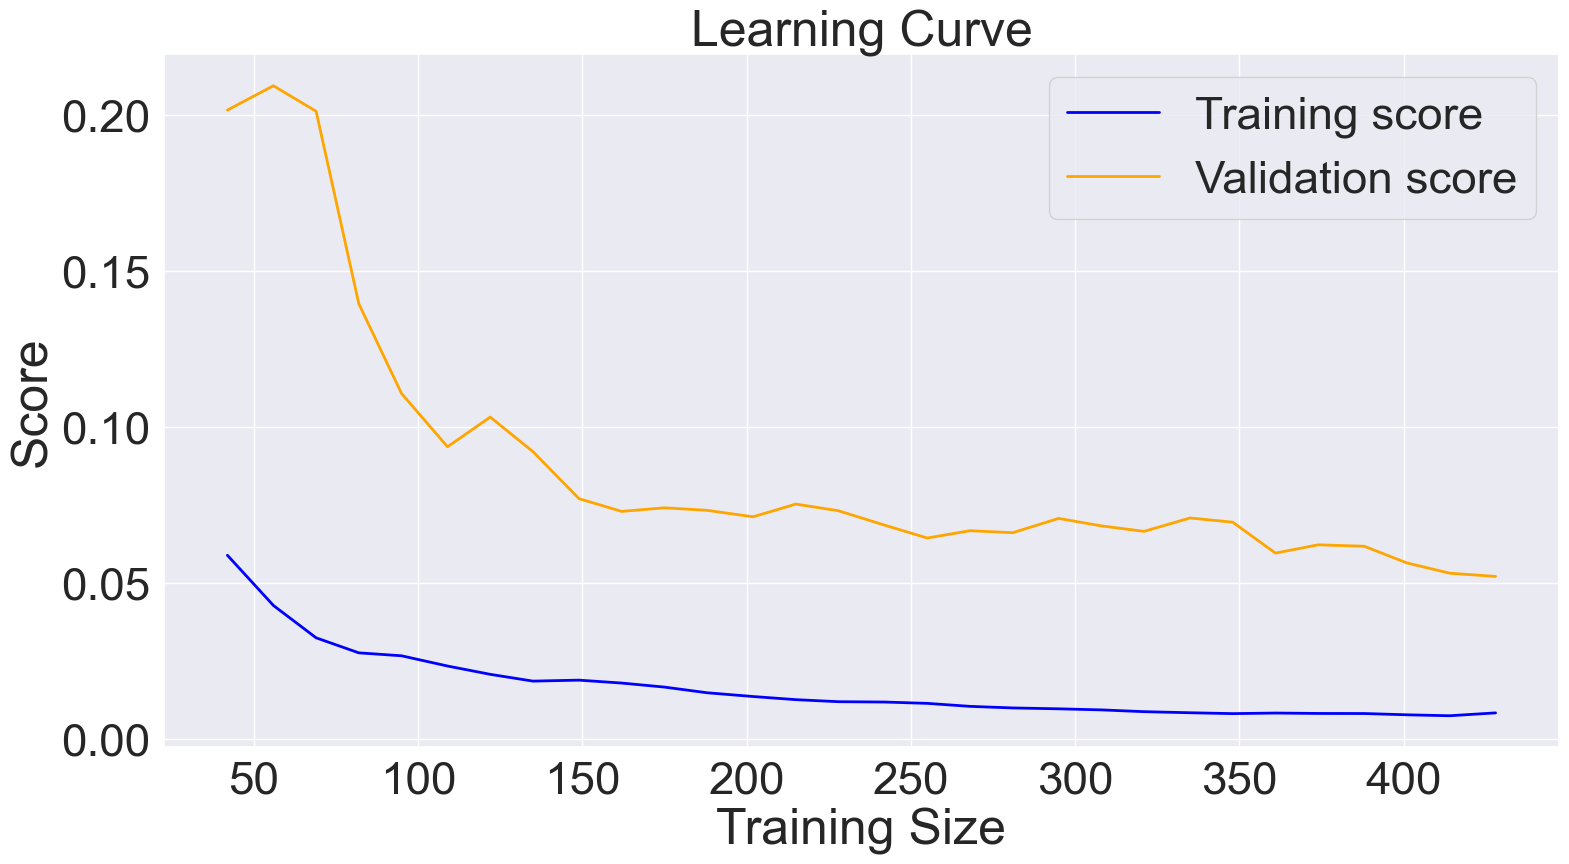

In [22]:
from sklearn.model_selection import learning_curve

cv = StratifiedKFold(n_splits=10)

train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y,
    train_sizes=np.linspace(0.1, 1, 30), 
    cv=cv, 
    scoring='neg_log_loss',  
    n_jobs=-1  
)

train_scores_mean = -np.mean(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
valid_scores_std = -np.std(valid_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', linewidth=2)
plt.plot(train_sizes, valid_scores_mean, label='Validation score', color='orange', linewidth=2)
plt.legend() 
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.show()

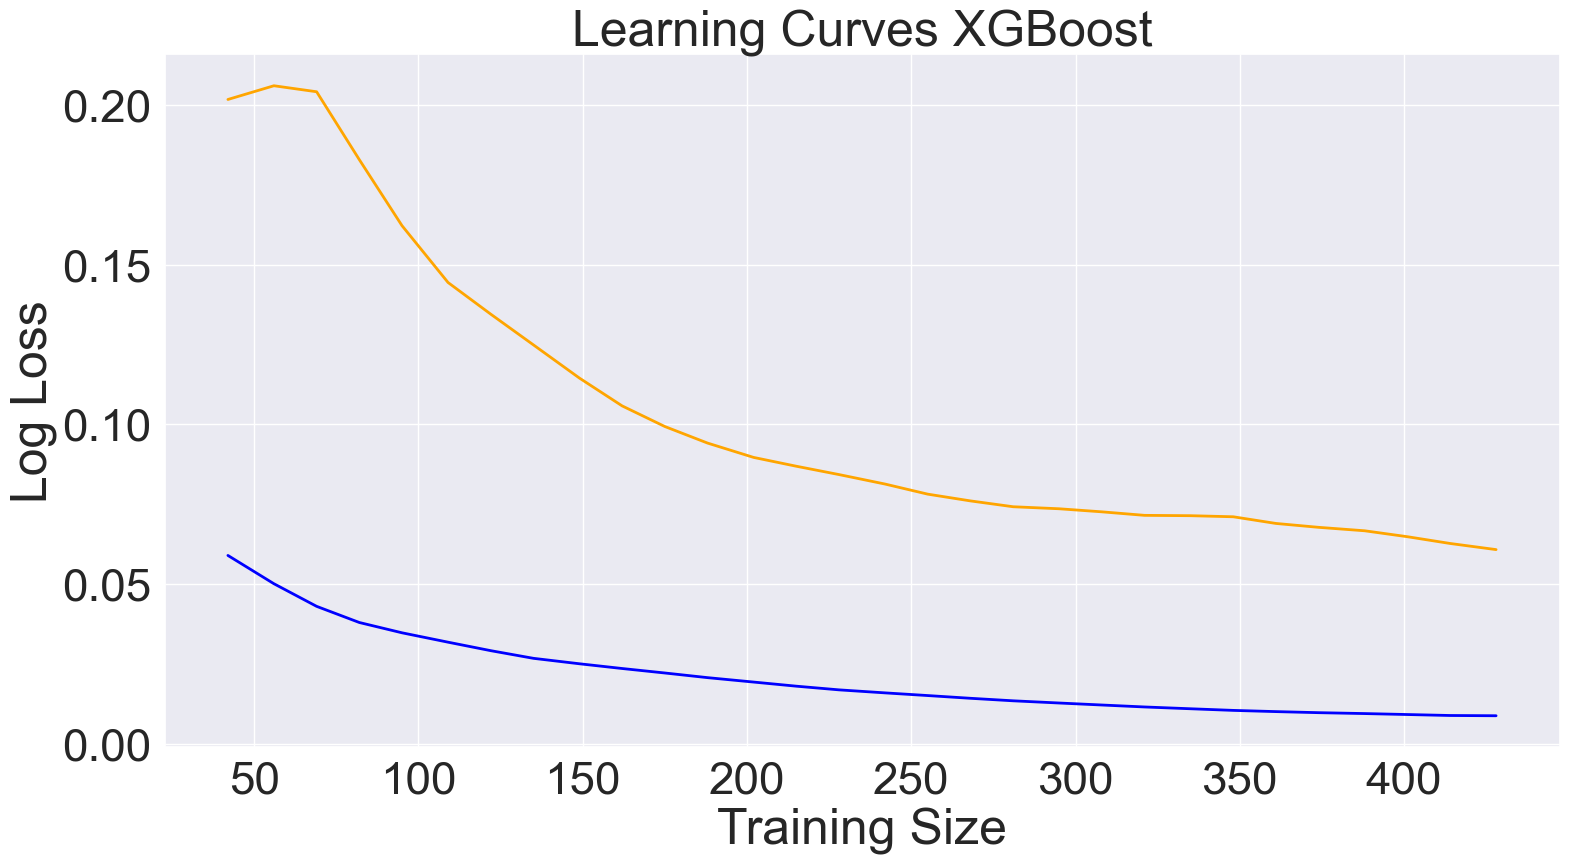

In [23]:
train_scores_smooth = pd.Series(train_scores_mean).ewm(span=10).mean()
valid_scores_smooth = pd.Series(valid_scores_mean).ewm(span=10).mean()

plt.plot(train_sizes, train_scores_smooth, label='Training score', color='blue', linewidth=2)
plt.plot(train_sizes, valid_scores_smooth, label='Cross-validation score', color='orange', linewidth=2)

plt.xlabel('Training Size')
plt.ylabel('Log Loss')
plt.title('Learning Curves XGBoost')
plt.show()

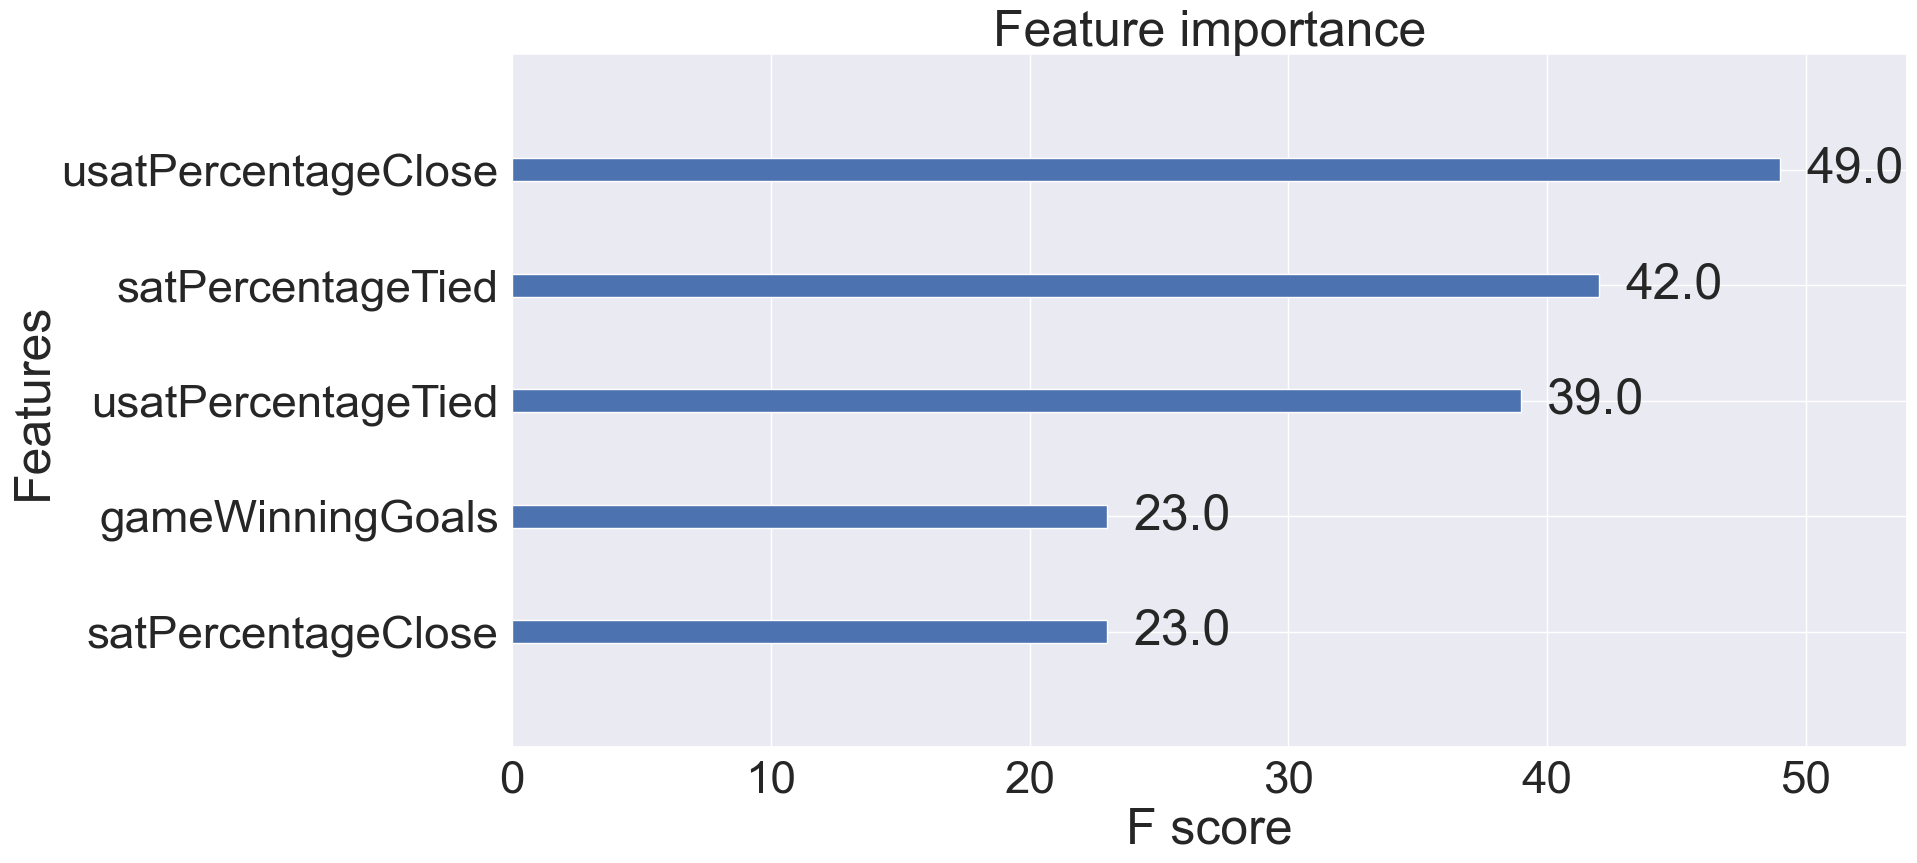

In [26]:
plot_importance(xgb_model)
plt.show()

In [27]:
x_var_adjusted = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageTied', 'satPercentageClose']
y_var = 'clutch_performance'

X_adjusted = df_players_merged[x_var_adjusted]
y = df_players_merged[y_var]

train_x, test_x, train_y, test_y = train_test_split(X_adjusted, y, test_size=0.2, random_state=50)

xgb_model_adjusted = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model_adjusted.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [28]:
from skopt import BayesSearchCV
import xgboost as xgb
import time
import math

scale_pos_weight = math.sqrt((df_players_merged['clutch_performance'] == 0).sum() / (df_players_merged['clutch_performance'] == 1).sum())

param_grid = {
    'max_depth': [1,3,5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.8] 
}

fit_params = {
'early_stopping_rounds': 15,
}


[0]	validation_0-logloss:0.45999	validation_1-logloss:0.43419
[1]	validation_0-logloss:0.40997	validation_1-logloss:0.38734
[2]	validation_0-logloss:0.36805	validation_1-logloss:0.34982
[3]	validation_0-logloss:0.33220	validation_1-logloss:0.31429
[4]	validation_0-logloss:0.29994	validation_1-logloss:0.28182
[5]	validation_0-logloss:0.27340	validation_1-logloss:0.25741
[6]	validation_0-logloss:0.24918	validation_1-logloss:0.23610
[7]	validation_0-logloss:0.22728	validation_1-logloss:0.21584
[8]	validation_0-logloss:0.20948	validation_1-logloss:0.19940
[9]	validation_0-logloss:0.19093	validation_1-logloss:0.18456
[10]	validation_0-logloss:0.17713	validation_1-logloss:0.17070
[11]	validation_0-logloss:0.16337	validation_1-logloss:0.15834
[12]	validation_0-logloss:0.15094	validation_1-logloss:0.14618
[13]	validation_0-logloss:0.13928	validation_1-logloss:0.13436
[14]	validation_0-logloss:0.12863	validation_1-logloss:0.12428
[15]	validation_0-logloss:0.11978	validation_1-logloss:0.11508
[1

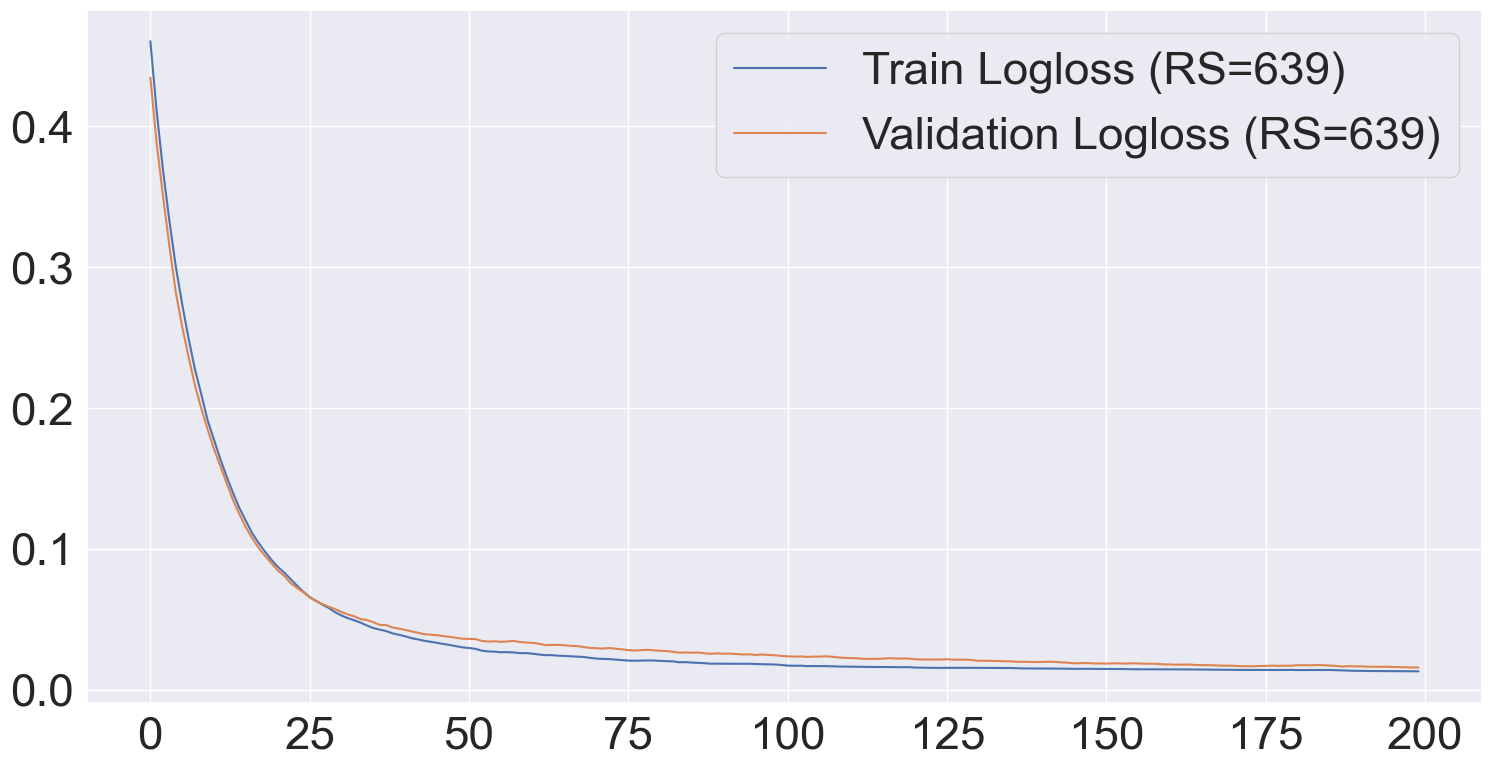

[0]	validation_0-logloss:0.23323	validation_1-logloss:0.24361
[1]	validation_0-logloss:0.13583	validation_1-logloss:0.13948
[2]	validation_0-logloss:0.09163	validation_1-logloss:0.09900
[3]	validation_0-logloss:0.06820	validation_1-logloss:0.07413
[4]	validation_0-logloss:0.05137	validation_1-logloss:0.05771
[5]	validation_0-logloss:0.04054	validation_1-logloss:0.04557
[6]	validation_0-logloss:0.03343	validation_1-logloss:0.03709
[7]	validation_0-logloss:0.02552	validation_1-logloss:0.02945
[8]	validation_0-logloss:0.02329	validation_1-logloss:0.03198
[9]	validation_0-logloss:0.02119	validation_1-logloss:0.03029
[10]	validation_0-logloss:0.02185	validation_1-logloss:0.03223
[11]	validation_0-logloss:0.02060	validation_1-logloss:0.02844
[12]	validation_0-logloss:0.02041	validation_1-logloss:0.02872
[13]	validation_0-logloss:0.01782	validation_1-logloss:0.02676
[14]	validation_0-logloss:0.01689	validation_1-logloss:0.02513
[15]	validation_0-logloss:0.01677	validation_1-logloss:0.02518
[1

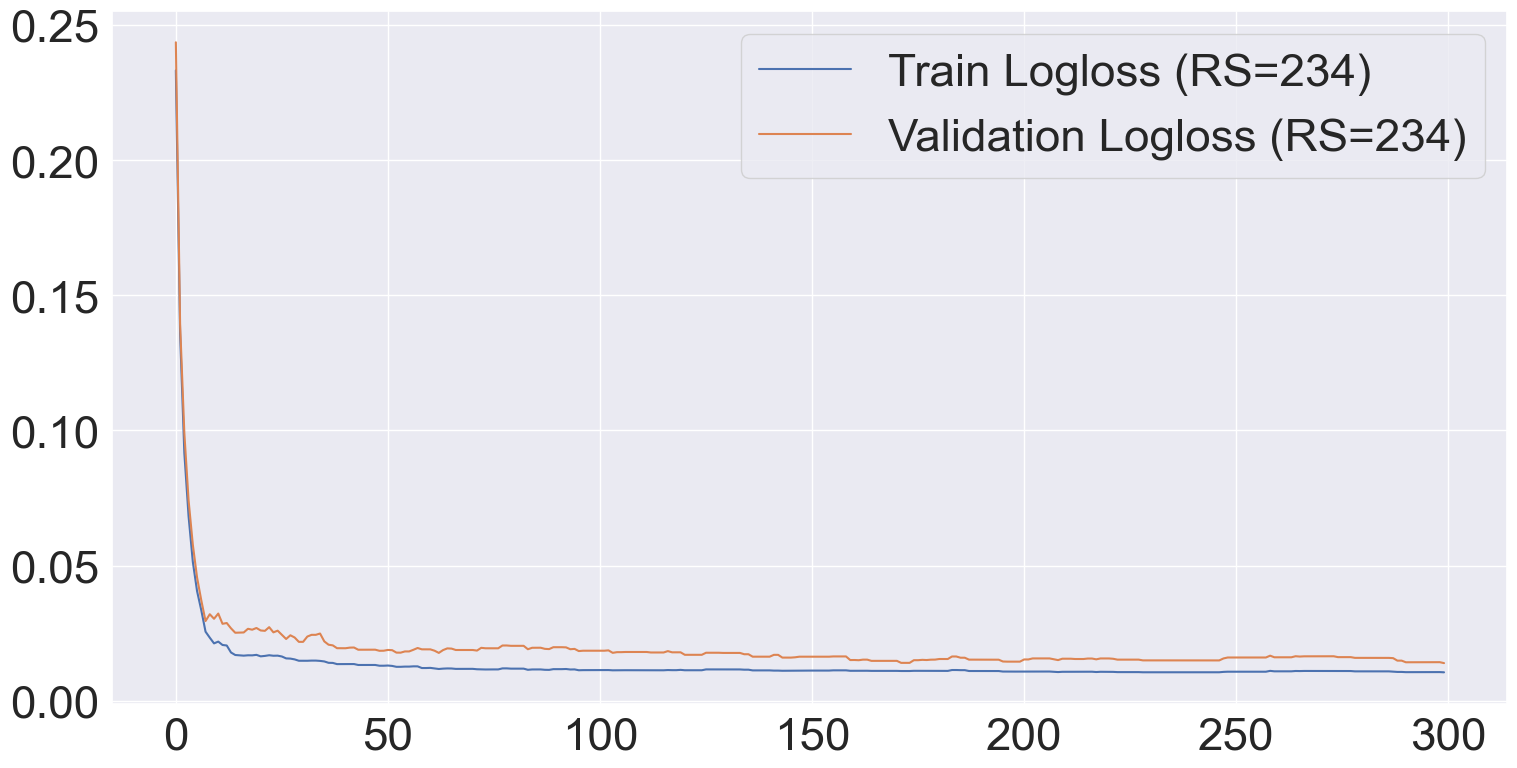

[0]	validation_0-logloss:0.45915	validation_1-logloss:0.43305
[1]	validation_0-logloss:0.40679	validation_1-logloss:0.38180
[2]	validation_0-logloss:0.36511	validation_1-logloss:0.34394
[3]	validation_0-logloss:0.32876	validation_1-logloss:0.30915
[4]	validation_0-logloss:0.29539	validation_1-logloss:0.27700
[5]	validation_0-logloss:0.26865	validation_1-logloss:0.25084
[6]	validation_0-logloss:0.24506	validation_1-logloss:0.22677
[7]	validation_0-logloss:0.22165	validation_1-logloss:0.20576
[8]	validation_0-logloss:0.20416	validation_1-logloss:0.18873
[9]	validation_0-logloss:0.18629	validation_1-logloss:0.17316
[10]	validation_0-logloss:0.17117	validation_1-logloss:0.15901
[11]	validation_0-logloss:0.15661	validation_1-logloss:0.14582
[12]	validation_0-logloss:0.14570	validation_1-logloss:0.13436
[13]	validation_0-logloss:0.13270	validation_1-logloss:0.12211
[14]	validation_0-logloss:0.12237	validation_1-logloss:0.11212
[15]	validation_0-logloss:0.11440	validation_1-logloss:0.10413
[1

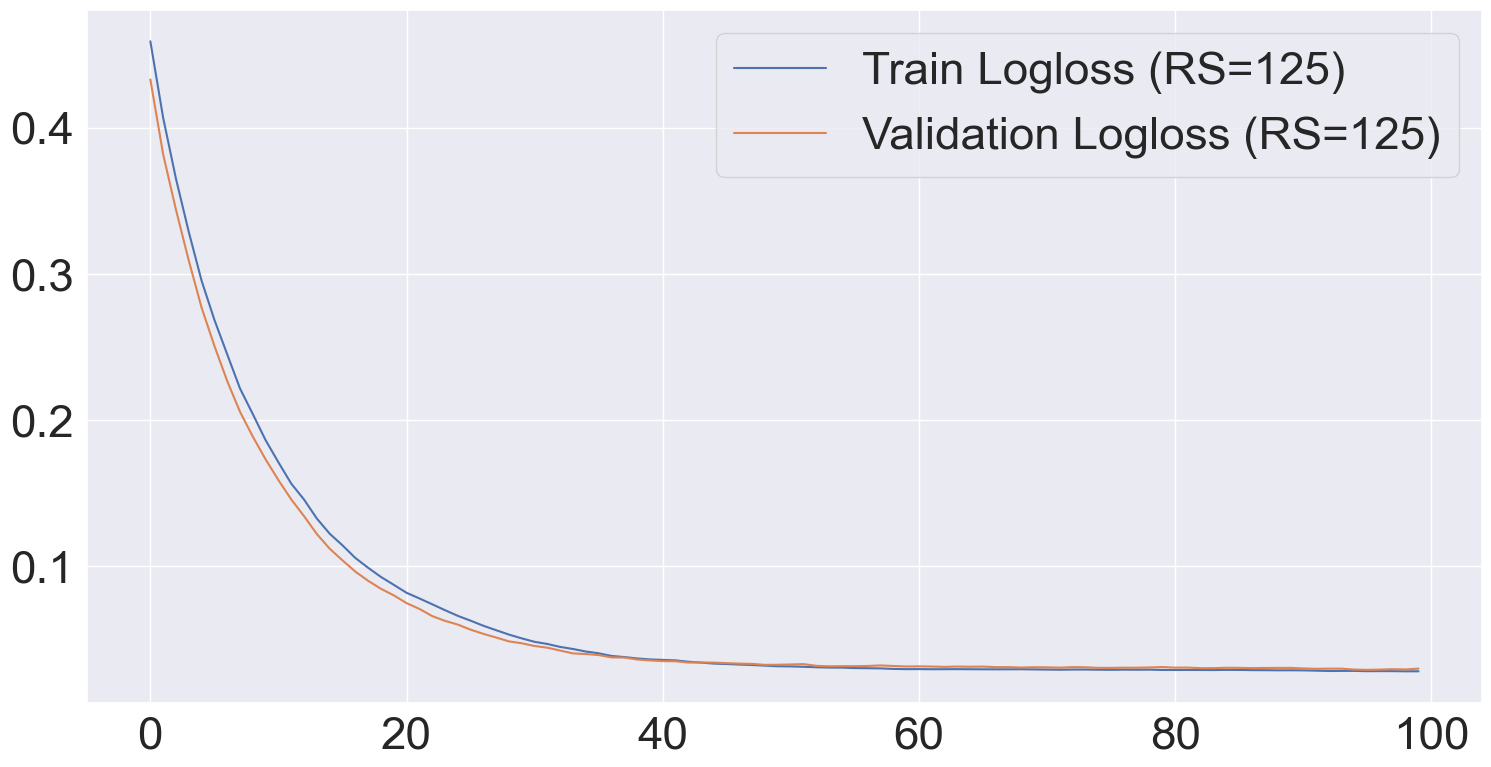

[0]	validation_0-logloss:0.47759	validation_1-logloss:0.45424
[1]	validation_0-logloss:0.43382	validation_1-logloss:0.40738
[2]	validation_0-logloss:0.39403	validation_1-logloss:0.36927
[3]	validation_0-logloss:0.36314	validation_1-logloss:0.33520
[4]	validation_0-logloss:0.33742	validation_1-logloss:0.31596
[5]	validation_0-logloss:0.31542	validation_1-logloss:0.29983
[6]	validation_0-logloss:0.29137	validation_1-logloss:0.27561
[7]	validation_0-logloss:0.27066	validation_1-logloss:0.25486
[8]	validation_0-logloss:0.25490	validation_1-logloss:0.24216
[9]	validation_0-logloss:0.24129	validation_1-logloss:0.23220
[10]	validation_0-logloss:0.22959	validation_1-logloss:0.22263
[11]	validation_0-logloss:0.21896	validation_1-logloss:0.21445
[12]	validation_0-logloss:0.20569	validation_1-logloss:0.20054
[13]	validation_0-logloss:0.19646	validation_1-logloss:0.19353
[14]	validation_0-logloss:0.18830	validation_1-logloss:0.18780
[15]	validation_0-logloss:0.17790	validation_1-logloss:0.17538
[1

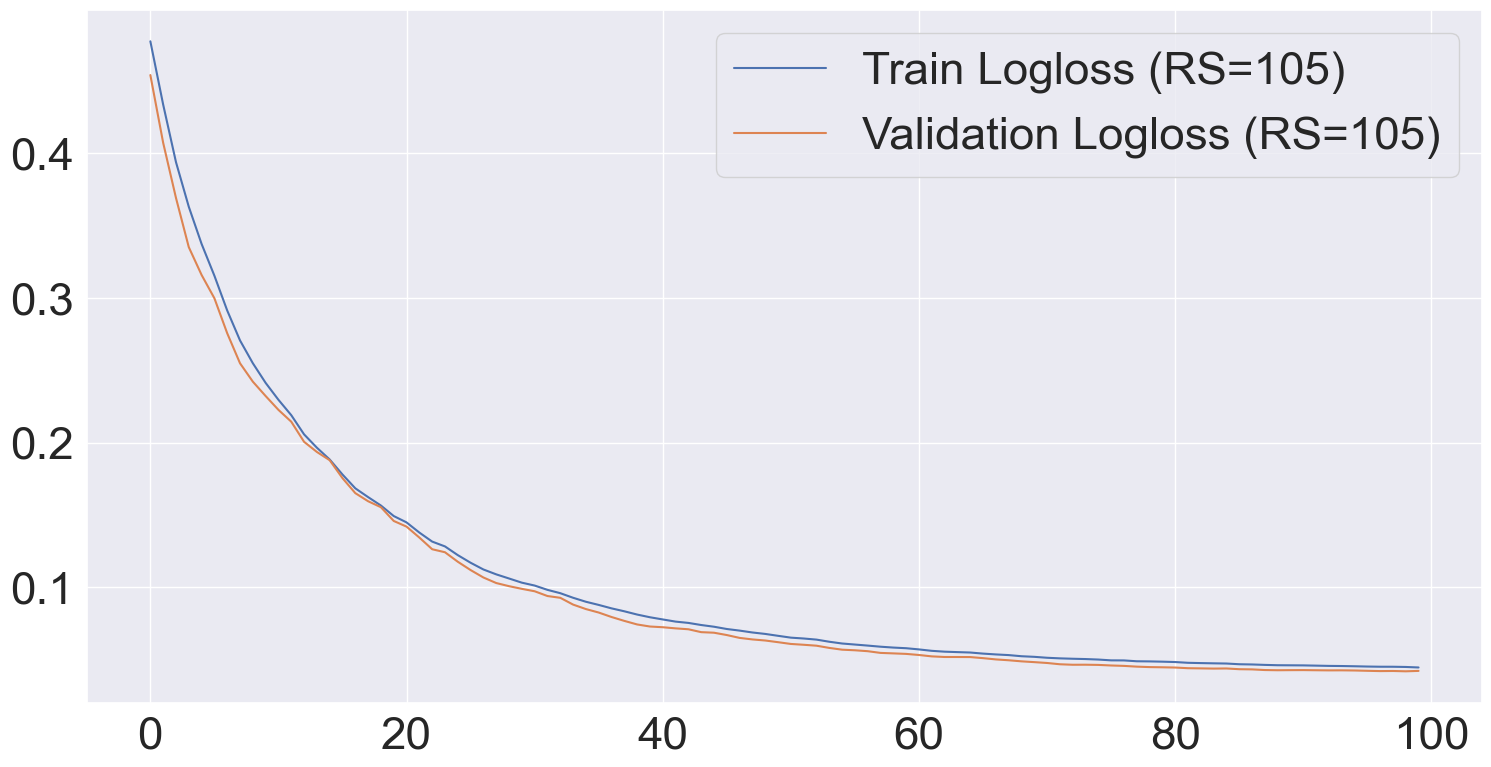

[0]	validation_0-logloss:0.45507	validation_1-logloss:0.42963
[1]	validation_0-logloss:0.40136	validation_1-logloss:0.37782
[2]	validation_0-logloss:0.35503	validation_1-logloss:0.33541
[3]	validation_0-logloss:0.31721	validation_1-logloss:0.29870
[4]	validation_0-logloss:0.28422	validation_1-logloss:0.26678
[5]	validation_0-logloss:0.25708	validation_1-logloss:0.23877
[6]	validation_0-logloss:0.23192	validation_1-logloss:0.21526
[7]	validation_0-logloss:0.20863	validation_1-logloss:0.19430
[8]	validation_0-logloss:0.18944	validation_1-logloss:0.17638
[9]	validation_0-logloss:0.17094	validation_1-logloss:0.16156
[10]	validation_0-logloss:0.15549	validation_1-logloss:0.14849
[11]	validation_0-logloss:0.14107	validation_1-logloss:0.13586
[12]	validation_0-logloss:0.12853	validation_1-logloss:0.12421
[13]	validation_0-logloss:0.11757	validation_1-logloss:0.11301
[14]	validation_0-logloss:0.10685	validation_1-logloss:0.10399
[15]	validation_0-logloss:0.09787	validation_1-logloss:0.09529
[1

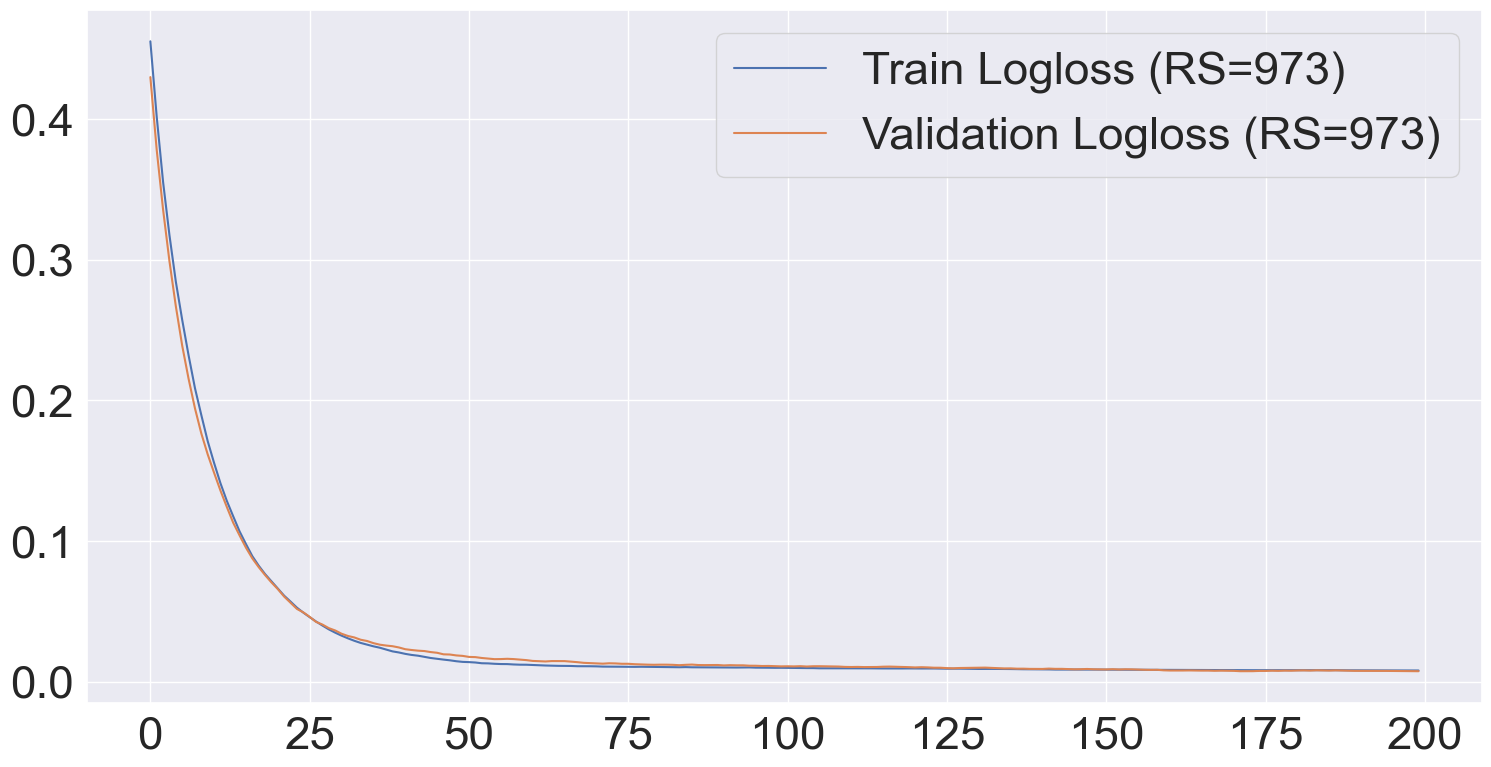

[0]	validation_0-logloss:0.26657	validation_1-logloss:0.31354
[1]	validation_0-logloss:0.17777	validation_1-logloss:0.16363
[2]	validation_0-logloss:0.08737	validation_1-logloss:0.08486
[3]	validation_0-logloss:0.08905	validation_1-logloss:0.08985
[4]	validation_0-logloss:0.06256	validation_1-logloss:0.07365
[5]	validation_0-logloss:0.05942	validation_1-logloss:0.07125
[6]	validation_0-logloss:0.04963	validation_1-logloss:0.06050
[7]	validation_0-logloss:0.05052	validation_1-logloss:0.05779
[8]	validation_0-logloss:0.04900	validation_1-logloss:0.05713
[9]	validation_0-logloss:0.04739	validation_1-logloss:0.05925
[10]	validation_0-logloss:0.05109	validation_1-logloss:0.05070
[11]	validation_0-logloss:0.05241	validation_1-logloss:0.05328
[12]	validation_0-logloss:0.05002	validation_1-logloss:0.05075
[13]	validation_0-logloss:0.05140	validation_1-logloss:0.05359
[14]	validation_0-logloss:0.04752	validation_1-logloss:0.04824
[15]	validation_0-logloss:0.04645	validation_1-logloss:0.04914
[1

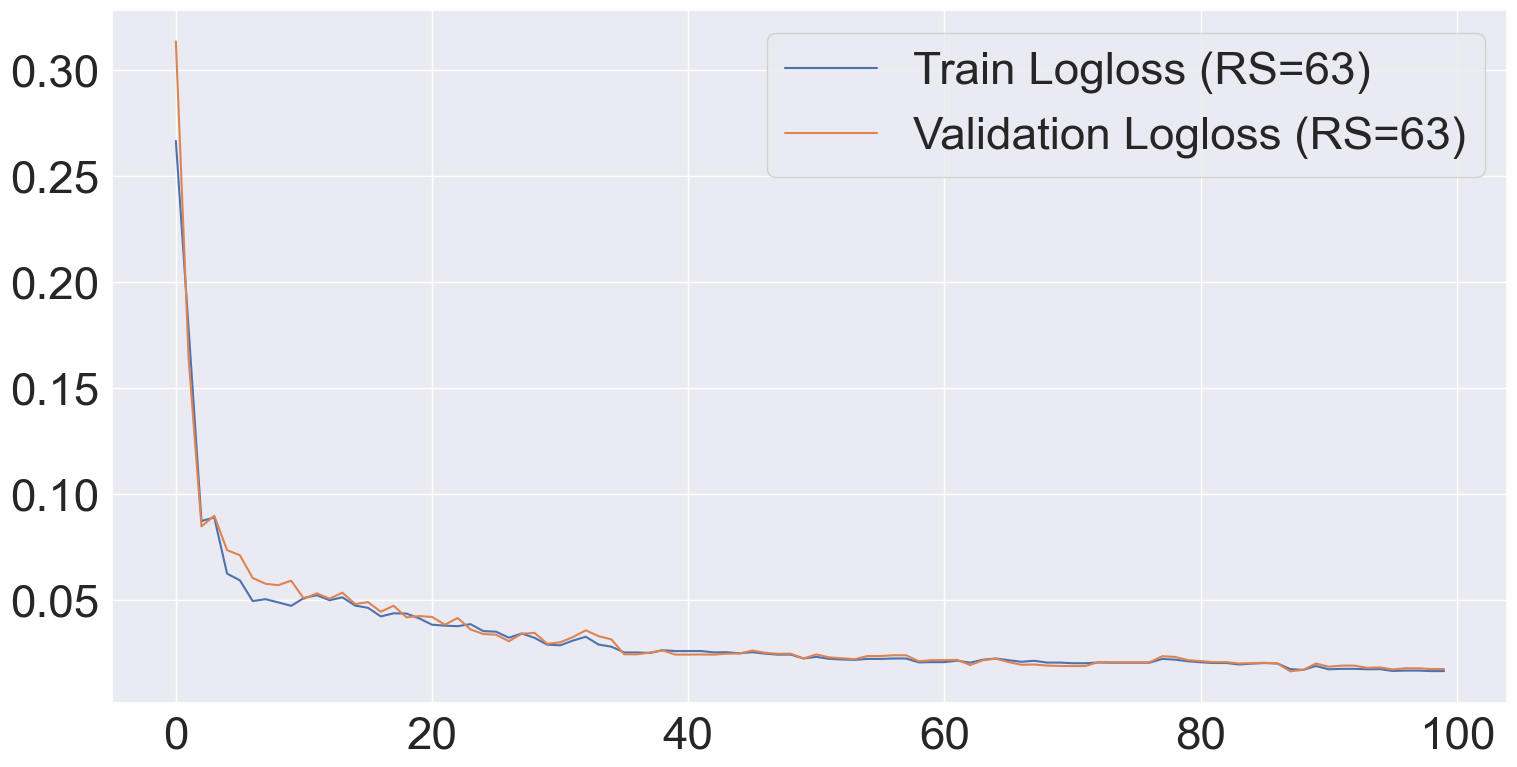

Average Accuracy: 0.9913194444444445
Average Precision: 0.9404761904761906
Average Recall: 1.0
Average F1 Score: 0.9691358024691358
Averaged Hyperparameters:
colsample_bytree      0.633333
learning_rate         0.333333
max_depth             3.000000
min_child_weight      1.666667
n_estimators        166.666667
reg_alpha             0.616667
reg_lambda            0.533333
scale_pos_weight      2.192003
subsample             0.700000
dtype: float64


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb

cv = StratifiedKFold(n_splits=10)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
best_hyperparams_list = []

for _ in range(6):

    rs = np.random.randint(1, 1000)
    
    bayes_search = BayesSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter= 20, n_jobs=-1, random_state = rs, fit_params = fit_params)
    evalset = [(train_x, train_y), (test_x, test_y)]
    bayes_search.fit(X_adjusted, y, eval_set=evalset)

    xgb_best_model = bayes_search.best_estimator_
    results = xgb_best_model.evals_result()

    pyplot.plot(results['validation_0']['logloss'], label=f'Train Logloss (RS={rs})')
    pyplot.plot(results['validation_1']['logloss'], label=f'Validation Logloss (RS={rs})')

    pyplot.legend()
    pyplot.show()

    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)[:, 1]

    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    best_hyperparams_list.append(bayes_search.best_params_)


print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))
print("Average F1 Score:", np.mean(f1_list))

hyperparams_df = pd.DataFrame(best_hyperparams_list)
averaged_hyperparams = hyperparams_df.mean()
print("Averaged Hyperparameters:")
print(averaged_hyperparams)

In [49]:
from sklearn.model_selection import permutation_test_score

score, permutation_scores, pvalue = permutation_test_score(
    xgb_model_adjusted, X_adjusted, y, random_state=0
)


In [50]:
pvalue

0.009900990099009901

In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score

xgb_best_model = bayes_search.best_estimator_

y_true = test_y 

y_pred = xgb_best_model.predict(test_x[x_var_adjusted])
y_pred_prob = xgb_best_model.predict_proba(test_x[x_var_adjusted])[:, 1]  

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_pr = average_precision_score(y_true, y_pred_prob)

print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("F1 Score:", round(f1, 2))
print("AUC PR:", round(auc_pr, 2))


Accuracy: 0.99
Precision: 0.93
Recall: 1.0
F1 Score: 0.96
AUC PR: 1.0


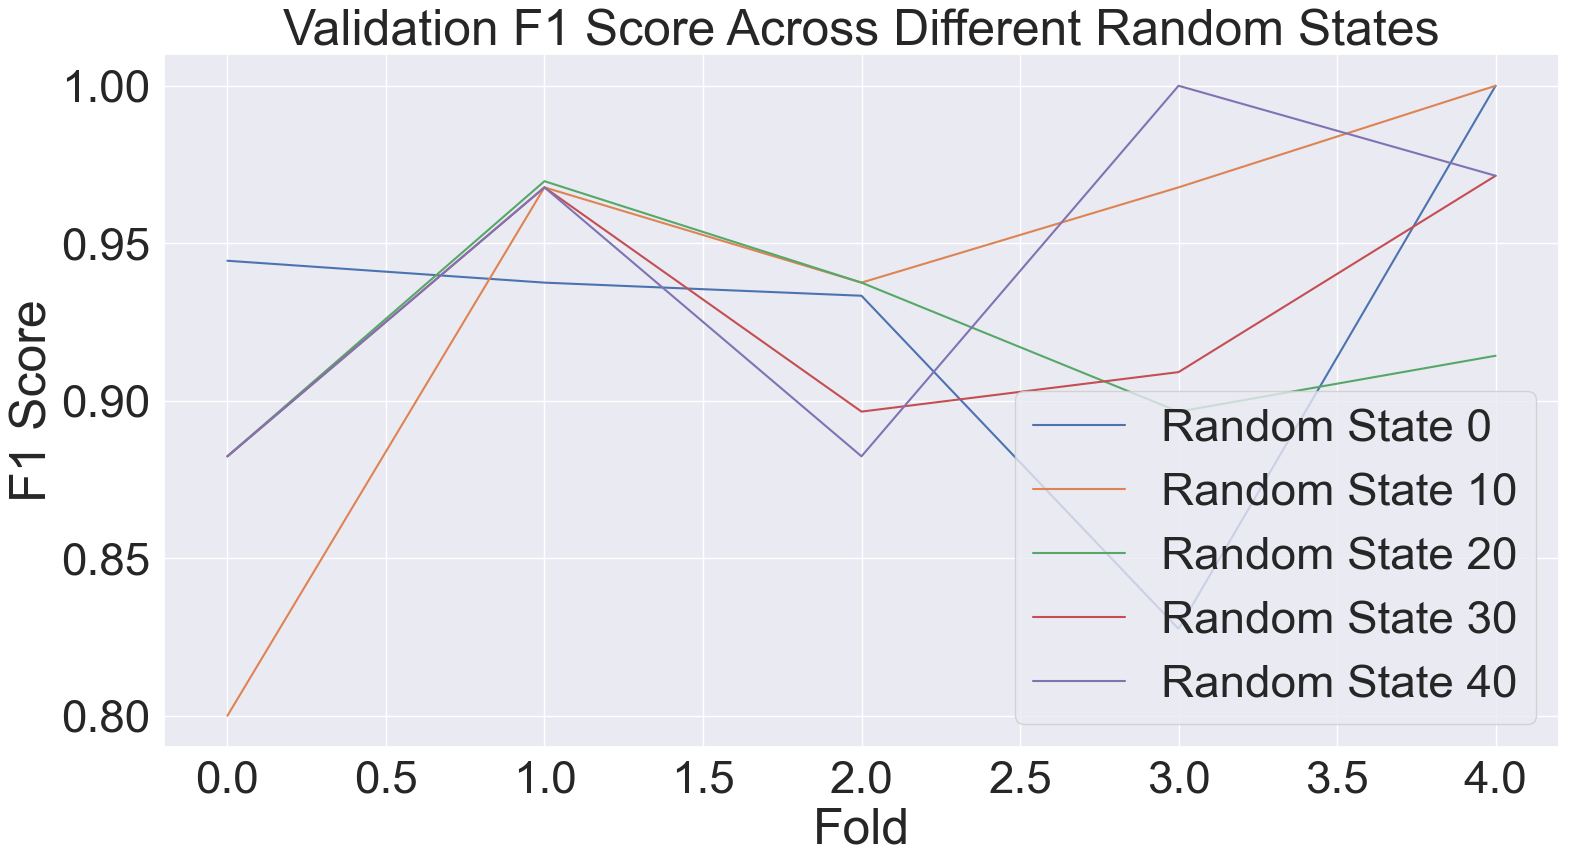

In [69]:
import matplotlib.pyplot as plt

random_states = [0, 10, 20, 30, 40]
for rs in random_states:
    train_scores = []
    val_scores = []
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)
    for train_idx, val_idx in cv.split(X, y):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
        model.fit(train_x, train_y)
        
        train_pred = model.predict(train_x)
        val_pred = model.predict(val_x)
        
        train_scores.append(f1_score(train_y, train_pred))
        val_scores.append(f1_score(val_y, val_pred))

    plt.plot(val_scores, label=f'Random State {rs}')
    
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score Across Different Random States')
plt.legend()
plt.show()


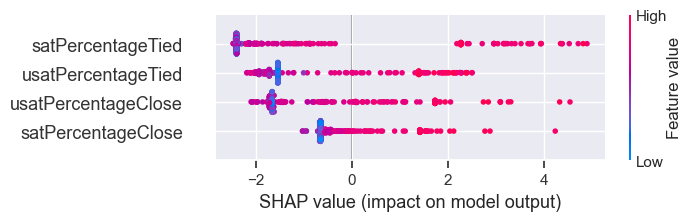

In [67]:
import shap

explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(train_xgb[x_var_adjusted])

shap.summary_plot(shap_values, train_xgb[x_var_adjusted])

In [42]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], train_xgb[x_var_adjusted].iloc[0])

NameError: name 'shap' is not defined

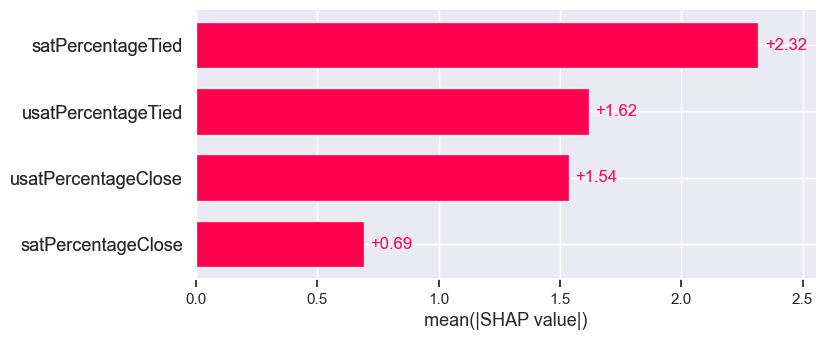

In [73]:
shap.plots.bar(shap_values)

In [102]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

train_xgb, test_xgb = train_test_split(random_sample, test_size=0.2, random_state=42)

evalset = [(train_xgb[x_var_adjusted], train_xgb[y_var]), (test_xgb[x_var_adjusted], test_xgb[y_var])]

xgb_best_model.fit(train_xgb[x_var_adjusted], train_xgb[y_var], eval_set=evalset, verbose=True)

y_pred_final = xgb_best_model.predict(test_xgb[x_var_adjusted])
y_pred_prob_final = xgb_best_model.predict_proba(test_xgb[x_var_adjusted])[:, 1]

[0]	validation_0-logloss:0.56224	validation_1-logloss:0.56961
[1]	validation_0-logloss:0.50006	validation_1-logloss:0.50637
[2]	validation_0-logloss:0.44693	validation_1-logloss:0.45241
[3]	validation_0-logloss:0.40412	validation_1-logloss:0.41778
[4]	validation_0-logloss:0.36397	validation_1-logloss:0.37638
[5]	validation_0-logloss:0.32892	validation_1-logloss:0.34022
[6]	validation_0-logloss:0.29815	validation_1-logloss:0.30847
[7]	validation_0-logloss:0.27102	validation_1-logloss:0.28047
[8]	validation_0-logloss:0.24892	validation_1-logloss:0.26310
[9]	validation_0-logloss:0.22739	validation_1-logloss:0.24049
[10]	validation_0-logloss:0.20823	validation_1-logloss:0.22035
[11]	validation_0-logloss:0.19113	validation_1-logloss:0.20236
[12]	validation_0-logloss:0.17583	validation_1-logloss:0.18625
[13]	validation_0-logloss:0.16210	validation_1-logloss:0.17179
[14]	validation_0-logloss:0.14977	validation_1-logloss:0.15879
[15]	validation_0-logloss:0.13868	validation_1-logloss:0.14708
[1

In [103]:
y_true = test_xgb[y_var]
y_pred = xgb_best_model.predict(test_xgb[x_var_adjusted])
y_pred_prob = xgb_best_model.predict_proba(test_xgb[x_var_adjusted])[:, 1]  

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

auc_pr = average_precision_score(y_true, y_pred_prob)

print("Accuracy:", round(accuracy,2))
print("Precision:", round(precision,2))
print("Recall:", round(recall,2))
print("F1 Score:", round(f1,2))
print("AUC PR:", round(auc_pr,2))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC PR: 1.0


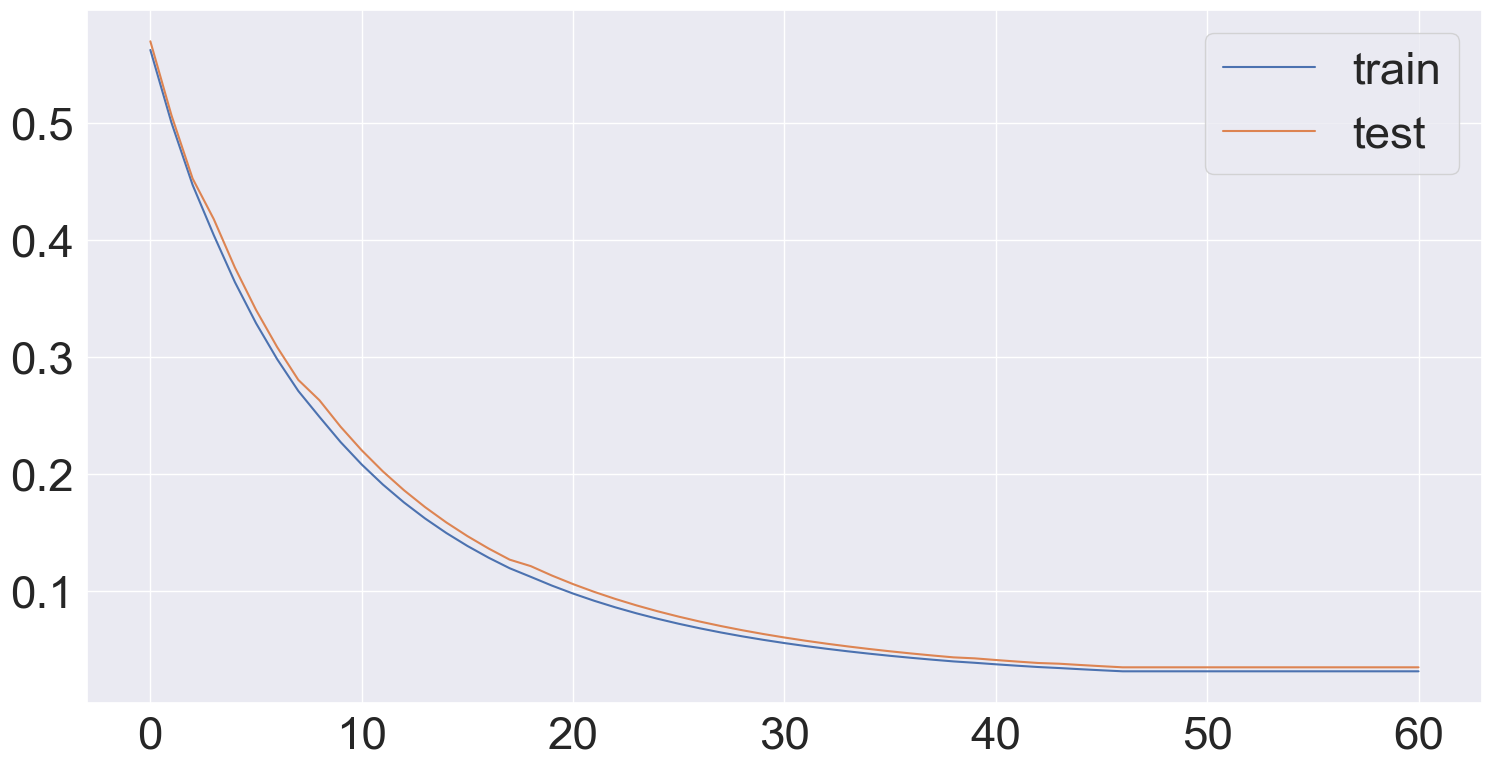

In [104]:
results = xgb_best_model.evals_result()

pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
pyplot.legend()
pyplot.show()

In [171]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score

# Step 1: Use the best model to make predictions on the test set
y_true = df_test['clutch_performance']  # True labels from the test set
y_pred = xgb_best_model.predict(df_test[x_var_adjusted])  # Make predictions

# Step 2: Calculate performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_pr = average_precision_score(y_true, xgb_best_model.predict_proba(df_test[x_var_adjusted])[:, 1])  # AUC-PR

# Step 3: Print the results
print("Test Set Metrics:")
print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("F1 Score:", round(f1, 2))
print("AUC PR:", round(auc_pr, 2))

Test Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC PR: 1.0


In [33]:
xgb_model.fit(train_xgb[x_var_adjusted], train_xgb[y_var])

y_train_pred = xgb_model.predict(train_xgb[x_var_adjusted])

y_test_pred = xgb_model.predict(test_xgb[x_var_adjusted])

train_accuracy = accuracy_score(train_xgb[y_var], y_train_pred)
train_precision = precision_score(train_xgb[y_var], y_train_pred)
train_recall = recall_score(train_xgb[y_var], y_train_pred)
train_f1 = f1_score(train_xgb[y_var], y_train_pred)

# Print results
print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy:.2f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}")


Training Set Metrics:
Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


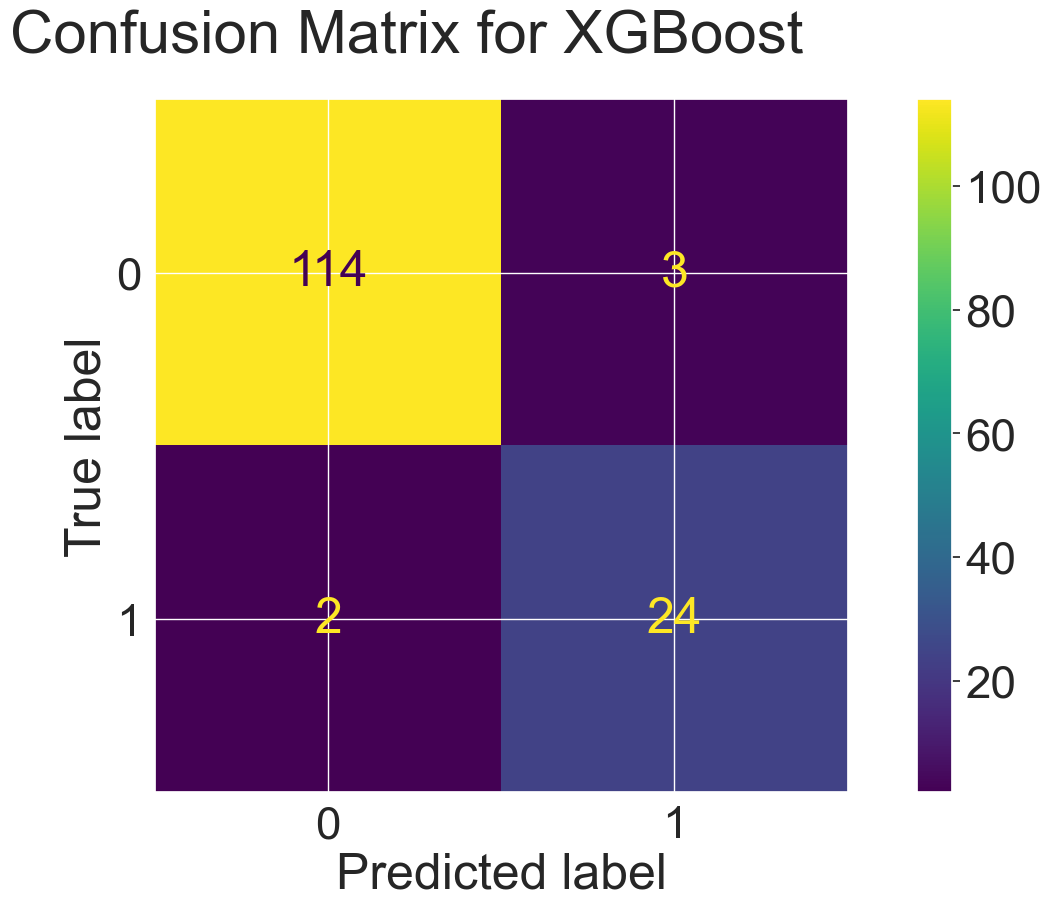

In [160]:
conf_matrix = confusion_matrix(y_pred_xgb, y_true_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [156]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = ['clutch_performance']
train, test = train_test_split(df_players_merged, test_size = 0.3)

random_forest_model = RandomForestClassifier(n_estimators=100)
random_forest_model.fit(train[x_var], train[y_var].values.ravel())

RandomForestClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

x_var_adjusted = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageTied']
y_var = 'clutch_performance'

scale_pos_weight = (df_players_merged['clutch_performance'] == 0).sum() / (df_players_merged['clutch_performance'] == 1).sum()

param_grid = {
    'max_depth': [1, 3, 5, 7],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda':[0.1, 0.5, 1.0]
    
}

random_search = RandomizedSearchCV(estimator = xgb_model, param_distributions = param_grid, cv = 5, n_jobs = -1,n_iter=100)

start_time = time.time()
random_search.fit(train_xgb[x_var_adjusted], train_xgb[y_var])
xgb_duration = time.time() - start_time

print("Best Parameters:", random_search.best_params_)
print ("Time: ", xgb_duration)

In [97]:
scores = cross_val_score(xgb_model, df_players_merged[x_var], df_players_merged[y_var].values.ravel(), cv=10)
scores

array([1.        , 0.97916667, 0.95833333, 1.        , 0.97916667,
       0.95833333, 0.9787234 , 1.        , 1.        , 0.95744681])

In [98]:
scores.mean()

0.9811170212765958

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 0.65, 'scale_pos_weight': 4.804878048780488, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.75}
Best Balanced Accuracy: 0.9749943039416724


In [101]:
best_model = random_search.best_estimator_
best_model.fit(train[x_var], train[y_var])

accuracy = best_model.score(test[x_var], test[y_var])
print("Accuracy:", accuracy)

Accuracy: 0.9440559440559441


In [102]:
cv_scores = cross_val_score(best_model, df_players_merged[x_var], df_players_merged[y_var], cv=10)

cv_scores

array([0.9375    , 0.97916667, 0.95833333, 0.97916667, 0.97916667,
       0.97916667, 0.95744681, 1.        , 0.9787234 , 0.95744681])

In [103]:
cv_scores.mean()

0.9706117021276597

In [104]:
y_pred = best_model.predict(test[x_var])  
y_true = test[y_var]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8055555555555556
Recall: 0.9666666666666667
F1 Score: 0.8787878787878789


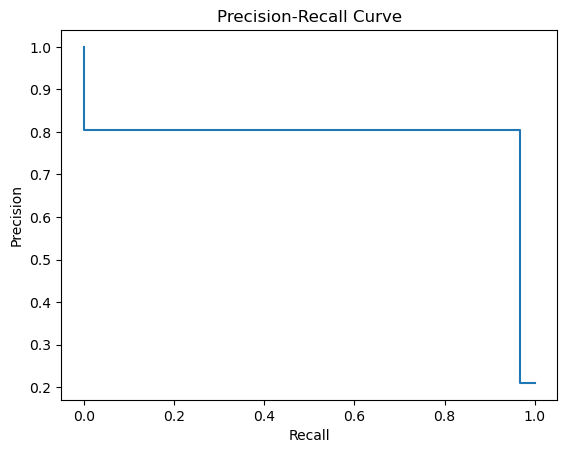

In [105]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

display = PrecisionRecallDisplay(precision=precision, recall=recall)

display.plot()

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")

plt.show()

In [107]:
probability = best_model.predict_proba(test[x_var])[:, 1]

auc_pr = average_precision_score(test[y_var], probability)

auc_pr

0.9817724867724869

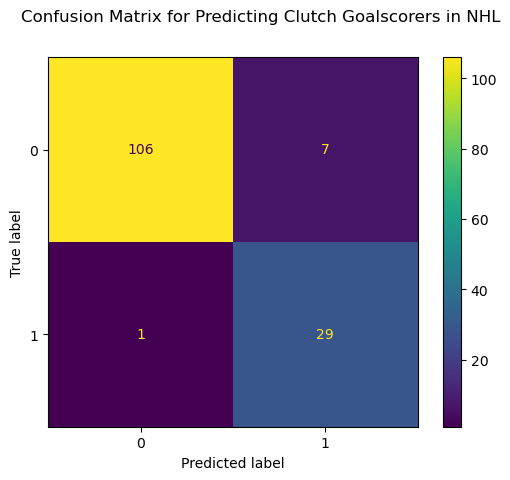

In [108]:
conf_matrix = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for Predicting Clutch Goalscorers in NHL')
plt.show()

In [109]:
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
accuracy

0.9440559440559441

In [110]:
df_players_merged['gameWinningGoalsPercentile'] = df_players_merged['gameWinningGoalsPercentile'].astype(str) + '%'
df_players_merged['tiedPercentile'] = df_players_merged['tiedPercentile'].astype(str) + '%'
df_players_merged['closePercentile'] = df_players_merged['closePercentile'].astype(str) + '%'
df_players_merged['final'] = df_players_merged['final'].astype(str) + '%'

In [111]:
df_players_merged.to_csv(r'C:\Users\shakj\Desktop\nhl_clutch_player_data1.csv', index=False)

In [112]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,...,satPercentageClosePercentile,satPercentageTiedPercentile,usatPercentageTiedPercentile,usatPercentageClosePercentile,gameWinningGoalsPercentile,tiedPercentile,closePercentile,final,finalRank,clutch_performance
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,46.4,43.6,40.1,...,27.94,15.13,3.99,13.76,36.97%,9.56%,20.85%,23.91%,399.0,0
1,8475763,Kevin Hayes,Hayes,R,STL,79,L,45.0,44.3,43.0,...,20.48,18.28,13.76,13.76,55.67%,16.02%,17.12%,32.21%,355.0,0
2,8471698,T.J. Oshie,Oshie,R,WSH,56,R,43.3,41.6,41.1,...,12.82,8.61,7.25,11.55,80.78%,7.93%,12.18%,38.35%,320.0,0
3,8482259,Bobby McMann,McMann,C,TOR,56,L,52.3,51.8,50.9,...,72.90,67.65,59.56,78.36,13.34%,63.6%,75.63%,47.1%,267.0,0
4,8480748,Kiefer Sherwood,Sherwood,L,NSH,74,R,52.0,53.5,53.4,...,70.38,78.26,76.16,70.80,55.67%,77.21%,70.59%,66.61%,123.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8474870,Tyler Johnson,Johnson,C,CHI,67,R,37.4,37.3,37.7,...,1.16,1.68,2.31,0.84,36.97%,2.0%,1.0%,15.69%,438.0,0
472,8475913,Mark Stone,Stone,R,VGK,63,R,45.5,43.1,42.1,...,21.85,13.34,10.82,20.80,87.82%,12.08%,21.33%,45.15%,281.0,0
473,8478831,Kevin Stenlund,Stenlund,C,FLA,105,R,48.8,51.1,48.8,...,44.33,61.03,43.70,33.82,70.17%,52.36%,39.08%,55.5%,207.0,0
474,8476483,Rickard Rakell,Rakell,R,PIT,70,R,52.7,52.8,52.5,...,76.05,74.16,71.64,66.49,55.67%,72.9%,71.27%,65.52%,130.0,0


In [113]:
df_players_merged['finalRank'] = df_players_merged['finalRank'].astype(int)

df_players_merged.rename(columns={'skaterFullName': 'Name', 'closePercentile': 'Close Percentile', 'tiedPercentile': 'Tied Percentile', 'closePercentile': 'Close Percentile', 'gameWinningGoalsPercentile': 'GWG Percentile', 'final': 'Clutch Percentile','finalRank': 'Rank'}, inplace=True)

df_players_merged[['Name', 'Close Percentile',  'Tied Percentile', 'Clutch Percentile', 'GWG Percentile', 'Rank']].sort_values('Rank', ascending=True).head(5)

,Name,Close Percentile,Tied Percentile,Clutch Percentile,GWG Percentile,Rank
399,Zach Hyman,97.0%,97.38%,97.73%,98.53%,1
188,Sebastian Aho,96.96%,96.12%,97.63%,99.26%,2
12,Seth Jarvis,96.64%,97.38%,97.2%,97.48%,3
252,Andrei Svechnikov,98.37%,94.02%,96.12%,96.01%,4
194,Sam Reinhart,93.48%,93.49%,96.09%,100.0%,5


In [114]:
df_players_merged[['Name', 'Close Percentile',  'Tied Percentile', 'GWG Percentile', 'Clutch Percentile', 'Rank']].sort_values('Rank', ascending=True).head(10)

,Name,Close Percentile,Tied Percentile,GWG Percentile,Clutch Percentile,Rank
399,Zach Hyman,97.0%,97.38%,98.53%,97.73%,1
188,Sebastian Aho,96.96%,96.12%,99.26%,97.63%,2
12,Seth Jarvis,96.64%,97.38%,97.48%,97.2%,3
252,Andrei Svechnikov,98.37%,94.02%,96.01%,96.12%,4
194,Sam Reinhart,93.48%,93.49%,100.0%,96.09%,5
338,Nathan MacKinnon,95.32%,93.65%,97.48%,95.68%,6
110,Aleksander Barkov,94.54%,94.7%,96.01%,95.18%,7
166,Mikko Rantanen,93.38%,91.23%,98.53%,94.8%,8
87,Connor McDavid,97.84%,95.28%,91.6%,94.58%,9
397,Artemi Panarin,90.44%,90.18%,97.48%,93.18%,10
